<img src="images/header.png" align="center"/>

## 1. Introduction

This is the Capstone Project for [Advanced Data Science with IBM Specialization Certificate](https://www.coursera.org/specializations/advanced-data-science-ibm?fbclid=IwAR3p2ZthalkKNP1kcyK3VfxRBKyrRnOWeowrrus5UQt1IL3O8tB7jRWkc4E) course. The use case of this project is to recognize well-known landmarks captured on photos. The task can be classified as a Multi-Class Classification problem where each sample is assigned to one and only one label. The task will be accomplished using both the Deep and Non-Deep Learning.

__Use case:__
- Automate the prediction of landmark labels directly from image pixels to help people organize their photo collections.

__Main goals:__
- Collect the dataset containing landmark pictures of three different classes.
- Explore the dataset and its quality for modeling.
- Create a Deep Learning model, evaluate it and measure its accuracy on test dataset.
- Create a Non-Deep Learning model, evaluate it and measure its accuracy on test dataset.
- Compare the results between Deep and Non-Deep Learning accuracies.

__Implemented algorithms:__
- Convolutional Neural Network for Deep Learning
- K-Nearest Neighbors for Non-Deep Learning

__Main technological components:__
- Anaconda Jupyter Notebook for editing and running the notebook project.
- Python 3.7.3 as a programming language.
- Keras as a higher-level (capable of running on top of TensorFlow, CNTK or Theano) neural networks library for implementing Deep Learning functionality.
- Laptop Dell Inspiron 3541: AMD 1.80 GHz, RAM 8.00 GB, AMD Radeon(TM) R4 Graphics.

## 2. Data

Data preparation pipeline.

<img src="images/data_preparation_pipeline.png" width="500" align="left"/>

### 2.1. Data Acquiring

The dataset is constructed using the [FlickrAPI](https://pypi.org/project/flickrapi/). It is a Python library that includes authorized and non-authorized access to the Flickr environment, upload and replace photos etc. Creating a high quality dataset is quite time consuming and labor intensive work. Therefore, the purpose of this research is to create a model containing a few sample class labels (Big_Ben, Eiffel_Tower, Taj_Mahal). With more classes, the complexity of the model also increases and without more data the accuracy also begins to fall.

Install missing libraries.

In [1]:
# !pip install flickrapi
# !pip install imutils
# !pip install webp

Import required libraries.

In [3]:
# data downloading
import json
import flickrapi
import urllib

# file operations
import os, cv2, shutil
from PIL import Image
from imutils import paths

# data preprocessing
import pandas as pd
import numpy as np

# data splitting
from sklearn.model_selection import train_test_split

# data visualization
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# neural network frameworks
from tensorflow.python import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

# algorithms
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization

# optimizers and losses
from keras.losses import categorical_crossentropy

# metrics
from sklearn.metrics import classification_report
from sklearn import metrics

# general
import time, random, logging

Configure file paths and dataset parameters.

In [4]:
CONFIG_FLICKR_AUTHORIZATION = 'config/flickr_authorization.json'
CONFIG_SIGHTSEEINGS = 'config/sightseeings.csv'
SCRAPED_DATASET = 'scraped_dataset\\'
DATASET_TRAIN = 'dataset\\train\\'
DATASET_VALIDATION = 'dataset\\validation\\'
DATASET_TEST = 'dataset\\test\\'

MAX_RESULT_SIZE = 3000
# The data is split into the train/test (80/20) and after that the train once again into the train/validation (80/20).
TRAIN_PROPORTION = 0.8

Define the helper functions required for data scraping.

In [4]:
def get_flickr_authorization_tokens():
    """
    Read from file authorization tokens needed for making connection to the Flickr API.
    
    :return: Dictionary of authorization tokens.
    """
    with open(CONFIG_FLICKR_AUTHORIZATION, 'r') as f:
        sp_authorization_tokens = json.load(f)
    return sp_authorization_tokens

In [5]:
def get_sightseeings():
    """
    Read sightseeings names from specified file.
    
    :return: List of sightseeings names.
    """
    selected_sightseeings = pd.read_csv(CONFIG_SIGHTSEEINGS, encoding='utf-8', sep="\t")    
    return list(selected_sightseeings['SIGHTSEEING'])

If there are no suitable public dataset, create it Yourself! Using the FlickrAPI and query key specified by sightseeings names the image files are downloaded for the dataset.

In [ ]:
# Get Flickr API authorization tokens
fl_authorization_tokens = get_flickr_authorization_tokens()

# Get Flickr API access key
flickr = flickrapi.FlickrAPI(fl_authorization_tokens.get('key'), fl_authorization_tokens.get('secret'), cache=True)
# Get sightseeings list
sightseeings = get_sightseeings()

for query_ind, query_key in enumerate(sightseeings):
    tgt_folder = '{}\\{}{}'.format(os.getcwd(), SCRAPED_DATASET, query_key.replace(" ", "_"))
    if not os.path.exists(tgt_folder):
        os.makedirs(tgt_folder)

    images = flickr.walk(text=query_key,
                         tags=query_key,
                         tag_mode='all',
                         extras='url_c',
                         per_page=100,
                         sort='relevance')

    for image_ind, image_file in enumerate(images):
        image_url = image_file.get('url_c')
        image_local_path = '{}\\{}'.format(tgt_folder, (str(image_ind)+'.jpg'))

        if image_url is not None:
            urllib.request.urlretrieve(image_url, image_local_path)

        if image_ind > MAX_RESULT_SIZE:
            break

### 2.2. Data Cleaning

The process of data cleaning is much more complicated with images than it is with numerical data. After scraping the images from the Internet many downloaded files may not contain the images that is specified by the search query. Here are some solutions to solve this problem:

- __Use a pretrained model:__ One potential approach would be to use a pretrained model to tag the scraped images to see if they contain an image specified by the search query or not.
- __Perform partial manual control:__ If the task is too specific it may be difficult to find a pretrained image recognition model. An alternative approach would then be to tag manually a small part of dataset images to have trustworthy labels. Then these images can be augmented until a reasonable amount and a trained classifier created. After that this simple model can be used as a “rough filter” to decide what images to include in the main modeling dataset.
- __Perform manual control:__ It means that all the images are visually checked and quality controlled by the user. It’s also the solution that was chosen for this project. It’s because the size of the dataset used in this project is not too big, the quality of downloaded images was quite good and no pretrained landmark recognition model was found.

### 2.3. Data Splitting

The dataset is split into train, test and validation sets with the following characteristics. The size of the whole dataset is 7500 images. First, the proportion of 80/20 is used to separate the test dataset (1500 images). After that once again the proportion of 80/20 is used to separate the train (4800 images) and validation (1200 images) datasets.

- __The train set:__ To fit the model weights.
- __The validation set:__ To estimate the prediction error for the trainable model.
- __The test set:__ To estimate the generalization error for the final model. The test set should be kept apart and be brought out only at the end of the data analysis.

Define the helper functions required for data splitting.

In [5]:
def get_dataset_proportions():
    """
    Calculate how many files the train, validation and test folder should contain.
    
    :return: Tuple of sizes of train, validation and test folder.
    """
    dataset_size = 2500
    # Split dataset into training and testing part
    train_size = dataset_size * TRAIN_PROPORTION
    test_size = dataset_size - train_size
    
    # Split training dataset into training and validation part
    train_size = train_size * TRAIN_PROPORTION
    validation_size = dataset_size - test_size - train_size
    
    return (train_size, validation_size, test_size)

In [6]:
def count_files(folder_path):
    """
    Count the number of files in the folder specified by the path parameter.
    
    :param folder_path: String to specify folder path.
    :return: Integer of number of files.
    """
    file_path = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    total_files = 0
    for file in file_path:
        total_files = total_files + len(os.listdir(file))
    return total_files

In [7]:
dataset_proportions = get_dataset_proportions()
TRAIN_SIZE = dataset_proportions[0]
VALIDATION_SIZE = dataset_proportions[1]
TEST_SIZE = dataset_proportions[2]

In [11]:
# Split dataset into train, validation and test folder.
source_folder = SCRAPED_DATASET

for root_folder, sub_folders, file_names in os.walk(source_folder):
    for sub_folder in sub_folders:
        file_ind = 1
        for file_name in os.listdir(os.path.join(root_folder, sub_folder)):
            destination_folder = os.path.join(DATASET_TRAIN, sub_folder)

            if file_ind >= TRAIN_SIZE and file_ind < (TRAIN_SIZE + VALIDATION_SIZE):
                destination_folder = os.path.join(DATASET_VALIDATION, sub_folder)
            elif file_ind > (TRAIN_SIZE + VALIDATION_SIZE):
                destination_folder = os.path.join(DATASET_TEST, sub_folder)

            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)

            source_path = os.path.join(root_folder, sub_folder, file_name)
            destination_path = os.path.join(destination_folder, file_name)
            file_ind += 1
            # copy files
            shutil.copy(source_path, destination_path)

count_train_files = count_files(DATASET_TRAIN)
print('[INFO] Train Dataset: {} files'.format(count_train_files))

count_validation_files = count_files(DATASET_VALIDATION)
print('[INFO] Validation Dataset: {} files'.format(count_validation_files))

count_test_files = count_files(DATASET_TEST)
print('[INFO] Test Dataset: {} files'.format(count_test_files))

[INFO] Train Dataset: 4800 files
[INFO] Validation Dataset: 1200 files
[INFO] Test Dataset: 1500 files


After splitting the dataset the directory structure looks as following:

<img src="images/directory_tree.jpg" width="700" align="left"/>

### 2.3. Data Exploration

Data exploration task on image files involves the examination of main image files characteristics - format, mode, width and height. For that we scan through the dataset directory, determine all the image files properties and save them into dataframe.

In [12]:
# Scan through the test dataset directory, determine image files properties ('Format', 'Mode', 'Width', 'Height') and 
# save them into dataframe.
folder_path = [f.path for f in os.scandir(SCRAPED_DATASET ) if f.is_dir()]
image_stat_df = pd.DataFrame(columns=['Format', 'Mode', 'Width', 'Height'])

for fld_ind, fld_value in enumerate(folder_path):
    file_names = [fn for fn in os.listdir(fld_value)]
    for fn_ind, fn_value in enumerate(file_names):
        fn_path = os.path.join(fld_value, fn_value)
        image = Image.open(fn_path)
        image_stat_df = image_stat_df.append({'Format': image.format,
                'Mode': image.mode,
                'Width': image.size[0],
                'Height': image.size[1]},
                ignore_index=True)
image_stat_df.head()

,Format,Mode,Width,Height
0,JPEG,RGB,1920,2343
1,JPEG,RGB,678,1023
2,JPEG,RGB,800,533
3,JPEG,RGB,800,600
4,JPEG,RGB,800,645


In [13]:
# Construct new dataframe containing maximum, median and minimum values of all the image files 'Width' and 'Height' properties.
mmm_df = pd.DataFrame(
    index=['Max','Median','Min'],
    data={
        'Width':[image_stat_df['Width'].max(), image_stat_df['Width'].median(), image_stat_df['Width'].min()],
        'Height':[image_stat_df['Height'].max(), image_stat_df['Height'].median(), image_stat_df['Height'].min()]
    }
)
display(mmm_df)

,Width,Height
Max,5985.0,6720.0
Median,685.0,600.0
Min,151.0,133.0


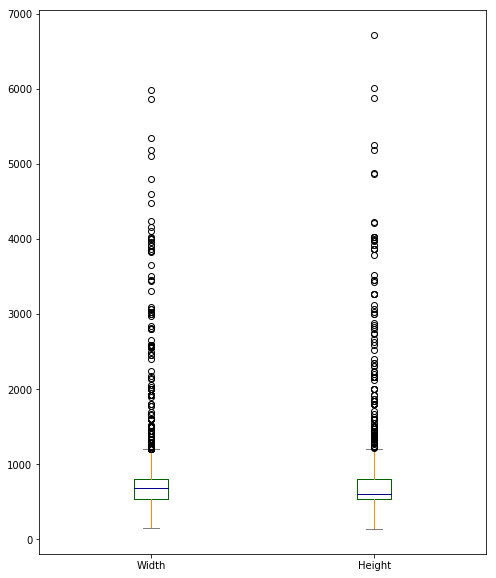

In [14]:
# Visualize image files 'Width' and 'Height' properties on Box plot chart.
bp_colors = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
bp_df = image_stat_df[['Width', 'Height']]
bp_df.plot.box(figsize=(8, 10), color=bp_colors)

Find unique elements.

In [15]:
image_stat_df['Format'].value_counts()

JPEG    7500
Name: Format, dtype: int64

In [16]:
image_stat_df['Mode'].value_counts()

RGB     7458
L         41
CMYK       1
Name: Mode, dtype: int64

From the previous analysis we can conclude the following:
- The average image file size is 5985.0 x 6720.0
- Some of them expand even to the size of 5985.0 x 6720.0.
- All files have the same JPEG extension.
- 7458 files are in the RGB mode. RGB means that images have 3 channels - one for red, one for green and one for blue.
- 41 files are in the L mode (greyscale). L mode is very compact but it has only single channel and stores only a greyscale not colour.
- 1 file is in the CMYK mode. CMYK stands for 'Cyan', 'Magenta', 'Yellow' and 'Black'.

## 3. Deep Learning

Data modeling pipeline.

<img src="images/data_modeling_pipeline.png" width="400" align="left"/>

### 3.1. Model Definition

The Convolutional Neural Network is a fully connected feed forward neural network. Due to the fact that the image data has high dimensionality and the number of parameters grows very fast, the pixel by pixel computing and model training is computationally complicated. But CNN is very effective in reducing the number of parameters without losing the quality of models. The main CNN components are as follows:

<img src="images/CNN_architecture.png" width="900" align="left"/>

- __Input Layer:__ Reads the image that is represented by three dimensional (RGB-channels) matrix. There are no parameters to learn here.

- __Convolution Layer:__ Extracts features from the input image such as edges, corners etc. Feature extraction is performed by convolution filters whose values are initialized randomly and then adjusted over several iterations of training (backpropagation). The input image is segmented into smaller pieces (feature maps) and the value of a destination pixel is a linear combination of the input and the sliding filter weights and biases. The scores are high if the filters are like the image and vice versa. Convolution returns as many feature maps as the number of filters used.

<img src="images/convolution.png" width="500" align="left"/>

- __Pooling Layer:__ Reduces the image dimension size while maintaining the most important information. If we had a 4x4 image the pooling operation would pick the max value from each 2x2 region. The activation map is now 25% of its original size. There are no parameters to learn here.

<img src="images/pooling.png" width="300" align="left"/>

- __Fully Connected Layer:__ Takes the features extracted in Convolution and Pooling layer and puts them through a feedforward neural network for classification. The main subcomponents of this layer are:
     - __Flatten:__ Converts the last matrix into a one-dimensional vector. It serves as a connection between the Convolution and Dense layers.
     - __Dense:__ Each neuron receives input from previous layer (thus densely connected).
     - __Dropout:__ A technique to reduce overfitting in CNN. It randomly drops units from a layer on each training step.
     <img src="images/fully_connected.png" width="500" align="left"/>

- __Activation functions:__ Decides whether a neuron should be activated or not. It maps the resulting values into the desired range. 
   - __ReLU function:__ Maps the output of neuron to the highest positive value. We can say, it is a ‘positive filter’. If output is negative, it maps it to the zero.
   - __Softmax function:__ Converts the score into probability values and data is classified into a corresponding class that has the highest probability value.

<img src="images/activations.png" width="800" align="left"/>

Define the model hyperparameters.

In [8]:
IMG_WIDTH, IMG_HEIGHT = 64, 64
NUMBER_OF_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 100
DROPOUT_RATE = 0.5

LOSS = 'categorical_crossentropy'
OPTIMIZER = 'rmsprop'
METRICS = ['accuracy']
CLASS_MODE = 'categorical'
CNN_MODEL_FILE_NAME = 'landmark_images_recognition.h5'

if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

Construct the model architecture. In this project the type of model architecture is selected *'Conv-Pool-Conv-Pool-Conv-Pool-Conv-Pool'*.

In [10]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(DROPOUT_RATE))

cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(DROPOUT_RATE))

# The number of nodes in last Dense layer must equal to the number of classes.
cnn_model.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))

<img src="images/model_scema.jpg" width="350" align="left"/>

Print out the model summary. The total number of trainable parameters (weights and biases) is 719,363.

In [11]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

### 3.2. Model Training

In [12]:
# Compile the model.
cnn_model.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

In [13]:
# Configure image augmentation to increase the number of images for training.
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [14]:
# Read train dataset images into memory.
train_generator = train_datagen.flow_from_directory(
    DATASET_TRAIN,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    seed=10)

Found 4800 images belonging to 3 classes.


In [15]:
# Configure image augmentation for testing (only rescaling).
validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# Read validation dataset images into memory.
validation_generator = validation_datagen.flow_from_directory(
    DATASET_VALIDATION,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    seed=10)

Found 1200 images belonging to 3 classes.


In [17]:
# Read test dataset images into memory.
test_generator = validation_datagen.flow_from_directory(
    DATASET_TEST,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False, # keep data in same order as labels
    seed=10)

Found 1500 images belonging to 3 classes.


In [18]:
# Start model training.
start_time = time.time()

history = cnn_model.fit_generator(
    train_generator,
    steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SIZE // BATCH_SIZE)

end_time = time.time()
print("[INFO] Time elapsed: {:.2f} seconds".format(end_time-start_time))

Epoch 1/100
50/50 [==============================] - 259s 5s/step - loss: 1.5059 - acc: 0.4600 - val_loss: 2.1312 - val_acc: 0.4792
Epoch 2/100
50/50 [==============================] - 180s 4s/step - loss: 1.3574 - acc: 0.4750 - val_loss: 2.1638 - val_acc: 0.4453
Epoch 3/100
50/50 [==============================] - 172s 3s/step - loss: 1.1445 - acc: 0.5338 - val_loss: 3.6624 - val_acc: 0.4010
Epoch 4/100
50/50 [==============================] - 191s 4s/step - loss: 1.0671 - acc: 0.5419 - val_loss: 3.6318 - val_acc: 0.4103
Epoch 5/100
50/50 [==============================] - 179s 4s/step - loss: 1.0113 - acc: 0.5444 - val_loss: 3.9459 - val_acc: 0.3542
Epoch 6/100
50/50 [==============================] - 181s 4s/step - loss: 0.9069 - acc: 0.5919 - val_loss: 1.3688 - val_acc: 0.5573
Epoch 7/100
50/50 [==============================] - 163s 3s/step - loss: 0.8579 - acc: 0.6106 - val_loss: 1.4258 - val_acc: 0.5326
Epoch 8/100
50/50 [==============================] - 184s 4s/step - loss: 0.

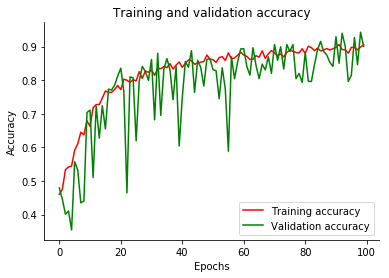

In [19]:
# Visualize the result of training and validation accuracy.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

ax = plt.subplot(111)

ax.plot(epochs, acc, 'r', label='Training accuracy')
ax.plot(epochs, val_acc, 'g', label='Validation accuracy')
ax.set_title('Training and validation accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend(loc=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

It can be seen that the model converges quite well over iterations but there are also some bigger fluctuations in validation accuracy.

Save the model weights and architecture into H5 data format (Hierarchical Data Format) file.

In [20]:
cnn_model.save(CNN_MODEL_FILE_NAME)

### 3.3. Model Evaluation

Load the previously saved model.

In [21]:
cnn_model = load_model(CNN_MODEL_FILE_NAME)

#### 3.3.1. Defining Prediction Metrics

The model is evaluated through Accuracy, Precision, Recall and F1-score which are the common metrics when it comes to judge the performance of image classification.

- __Accuracy:__ The proportion of total number of predictions that were correctly identified.

- __Precision:__ The proportion of positive cases that were correctly identified. Or in other words: "For all instances classified positive, what percent was correct?”

- __Recall/Sensitivity:__ The proportion of actual positive cases that were correctly identified. Or in other words: "For all instances that were actually positive, what percent was classified correctly?”

- __F1-score:__ Weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.

In [22]:
# Calculate the Accuracy score.
cnn_acc_score = cnn_model.evaluate_generator(test_generator)

In [23]:
print("[INFO] CNN model accuracy score for Test Dataset: {:.1f}%".format(cnn_acc_score[1]*100))

[INFO] CNN model accuracy score for Test Dataset: 91.7%


It means that in a Test Dataset of __1500 files__ there were __1376 correctly__ and __124 uncorrectly__ identified images.

In [24]:
# Calculate the Precision, Recall and F1 scores.

# Get actual classes
true_classes = test_generator.classes

# Calculate steps per epoch
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
test_generator.reset()
probabilities = cnn_model.predict_generator(test_generator, steps=test_steps_per_epoch)

# Get most likely classes (choose only maximum value)
predicted_class_indices = np.argmax(probabilities, axis=1) 

# Get class labels (Big_Ben, Eiffel_Tower, Taj_Mahal)
class_labels = list(test_generator.class_indices.keys())

# Calculate classification report
cnn_cf_report = classification_report(true_classes, predicted_class_indices, target_names=class_labels, digits=3)
print(cnn_cf_report)

              precision    recall  f1-score   support

     Big_Ben      0.846     0.948     0.894       500
Eiffel_Tower      0.935     0.918     0.926       500
   Taj_Mahal      0.984     0.884     0.932       500

   micro avg      0.917     0.917     0.917      1500
   macro avg      0.922     0.917     0.917      1500
weighted avg      0.922     0.917     0.917      1500



As the F1-score shows, the model gave best results in predicting 'Taj_Mahal' class label __(93.2%)__, then 'Eiffel_Tower' __(92.6%)__ and the last one was 'Big_Ben' __(89.4%)__. The weighted average F1-score was __91.7%__.

#### 3.3.2. Visualizing Predictions

Construct a dataframe containing the name of picture file, predicted class, verification code and the probability values.

In [18]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_class_labels = [labels[k] for k in predicted_class_indices]

img_file_names = test_generator.filenames
results_df = pd.DataFrame({"PICTURE_NAME":img_file_names, "PREDICTED_CLASS":predicted_class_labels})

results_df['VERIFICATION'] = results_df.apply(lambda x: x.PREDICTED_CLASS in x.PICTURE_NAME, axis=1)

for ind, class_label in enumerate(class_labels):
    results_df.insert(loc=ind+3, column=class_label.upper()+"_PROB", value=probabilities[:,ind].round(4))

results_df.head(10)

,PICTURE_NAME,PREDICTED_CLASS,VERIFICATION,BIG_BEN_PROB,EIFFEL_TOWER_PROB,TAJ_MAHAL_PROB
0,Big_Ben\Big_Ben_549.jpg,Big_Ben,True,0.9999,0.0001,0.0000
1,Big_Ben\Big_Ben_55.jpg,Eiffel_Tower,False,0.0838,0.9154,0.0008
2,Big_Ben\Big_Ben_550.jpg,Big_Ben,True,1.0000,0.0000,0.0000
3,Big_Ben\Big_Ben_551.jpg,Big_Ben,True,1.0000,0.0000,0.0000
4,Big_Ben\Big_Ben_552.jpg,Big_Ben,True,0.9106,0.0864,0.0029
5,Big_Ben\Big_Ben_553.jpg,Big_Ben,True,0.9991,0.0009,0.0000
6,Big_Ben\Big_Ben_554.jpg,Big_Ben,True,0.9975,0.0022,0.0003
7,Big_Ben\Big_Ben_555.jpg,Big_Ben,True,0.9985,0.0014,0.0001
8,Big_Ben\Big_Ben_556.jpg,Big_Ben,True,1.0000,0.0000,0.0000
9,Big_Ben\Big_Ben_557.jpg,Big_Ben,True,0.9999,0.0001,0.0000


Select 10 random rows from Test Dataset.

In [195]:
number_of_samples = 10
random_rows = random.sample(range(int(NUMBER_OF_CLASSES*TEST_SIZE)), number_of_samples)
filtered_results_df = results_df.iloc[random_rows].sort_values(['PREDICTED_CLASS'], ascending=True, axis=0)
filtered_results_df.reset_index(drop=True, inplace=True)
filtered_results_df

,PICTURE_NAME,PREDICTED_CLASS,VERIFICATION,BIG_BEN_PROB,EIFFEL_TOWER_PROB,TAJ_MAHAL_PROB
0,Big_Ben\Big_Ben_893.jpg,Big_Ben,True,0.9999,0.0001,0.0000
1,Big_Ben\Big_Ben_697.jpg,Big_Ben,True,0.9647,0.0348,0.0005
2,Big_Ben\Big_Ben_9.jpg,Big_Ben,True,0.9998,0.0002,0.0000
3,Eiffel_Tower\Eiffel_Tower_988.jpg,Eiffel_Tower,True,0.0000,1.0000,0.0000
4,Eiffel_Tower\Eiffel_Tower_666.jpg,Eiffel_Tower,True,0.0001,0.9999,0.0000
5,Taj_Mahal\Taj_Mahal_577.jpg,Eiffel_Tower,False,0.0265,0.7355,0.2380
6,Eiffel_Tower\Eiffel_Tower_812.jpg,Eiffel_Tower,True,0.1782,0.8189,0.0029
7,Eiffel_Tower\Eiffel_Tower_838.jpg,Eiffel_Tower,True,0.1102,0.8839,0.0059
8,Taj_Mahal\Taj_Mahal_78.jpg,Taj_Mahal,True,0.0000,0.0000,1.0000
9,Taj_Mahal\Taj_Mahal_726.jpg,Taj_Mahal,True,0.0351,0.0047,0.9602


Filter out the columns of probabilities.

In [196]:
probs_df = filtered_results_df.loc[:, ('BIG_BEN_PROB', 'EIFFEL_TOWER_PROB', 'TAJ_MAHAL_PROB')]
probs_df.head()

,BIG_BEN_PROB,EIFFEL_TOWER_PROB,TAJ_MAHAL_PROB
0,0.9999,0.0001,0.0000
1,0.9647,0.0348,0.0005
2,0.9998,0.0002,0.0000
3,0.0000,1.0000,0.0000
4,0.0001,0.9999,0.0000


Define the helper function required for visualization.

In [21]:
def generate_prob_chart(y_label, y_pos, probs, picture_index):
    """
    Generate probability chart for each prediction made.
    
    :param y_label: String of class label value.
    :param y_pos: Integer of class label index.
    :param probs: List of classes probability values.
    :param picture_index: Integer of picture index.
    """
    # Draw plot
    fig, ax = plt.subplots(figsize=(9, 6), dpi= 100)
    ax.hlines(y=y_pos, xmin=0, xmax=probs, color='firebrick', alpha=0.7, linewidth=2)
    ax.scatter(y=y_pos, x=probs, s=75, color='firebrick', alpha=0.7)

    # Set plot's attributes
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_label, rotation=45, fontdict={'horizontalalignment': 'right', 'size':12})
    ax.set_xlim(0, max(probs)+(0.15*max(probs)))
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

    # Annotate plot
    for i, j in enumerate(probs):
        ax.text(j+.07, i, s=round(j, 2), horizontalalignment= 'center', verticalalignment='center', fontsize=12)
    
    # Save each plot into separate file.
    plt.savefig("images/prob_"+str(picture_index)+".jpg", dpi=100)
    plt.close(fig)

In [204]:
# Visualize predictions showing for each picture it's predicted class, probability values and verification approval.

# Construct the lists of class labels and their indices.
y_label = list(map(lambda x: x.replace("_", " "), list(test_generator.class_indices.keys())))
y_label.reverse()
y_pos = [i for i, j in enumerate(y_label)]

# The table header colums.
html_table = ''.join(("<html><table><tr>",
                    "<td style='text-align: center;'><strong>PICTURE</strong></td>",
                    "<td style='text-align: center;'><strong>PREDICTED CLASS</strong></td>",
                    "<td style='text-align: center;'><strong>PROBABILITIES</strong></td>",
                    "<td style='text-align: center;'><strong>VERIFICATION</strong></td></tr>"))

# Loop over filtered results and construct the table.
for df_index, df_row in filtered_results_df.iterrows():
    img_path = (DATASET_TEST+df_row['PICTURE_NAME']).replace("\\", "/")
    img_file = cv2.imread(img_path)
    cv2.imwrite("images/picture_"+str(df_index)+".jpg", img_file)
    picture_img_cell = "<img src='images/picture_"+str(df_index)+".jpg' height='250' width='250'/>"
    
    pred_class = df_row.at['PREDICTED_CLASS']
    veriff_value = df_row.at['VERIFICATION']
    
    probs = probs_df.values.tolist()[df_index]
    probs.reverse()
    generate_prob_chart(y_label, y_pos, probs, df_index)
    prob_img_cell = "<img src='images/prob_"+str(df_index)+".jpg' height='400' width='400'/>"
    
    if veriff_value:
        veriff_img_cell = "<img src='images/check_mark_green.png' height='80' width='80' style='background:transparent;'/>"
    else:
        veriff_img_cell = "<img src='images/check_mark_red.png' height='80' width='80' style='background:transparent;'/>"
    
    # Concatenate the current row columns.
    html_row = ''.join(("<tr>",
        "<td>"+picture_img_cell+"</td>",
        "<td><strong>"+pred_class.replace("_", " ")+"</strong></td>",
        "<td>"+prob_img_cell+"</td>",
        "<td>"+veriff_img_cell+"</td>",
        "</tr>"))
    html_table = html_table + html_row

html_table = html_table+"</table></html>"    
display(HTML(html_table))

PICTURE,PREDICTED CLASS,PROBABILITIES,VERIFICATION
,Big Ben,,
,Big Ben,,
,Big Ben,,
,Eiffel Tower,,
,Eiffel Tower,,
,Eiffel Tower,,
,Eiffel Tower,,
,Eiffel Tower,,
,Taj Mahal,,
,Taj Mahal,,


## 4. Non-Deep Learning

Image pixels are usually saved as 32 bit integers. The RGBA colour model is formed by four channels, each represented by 8 bit (giving a range between 0 and 255). The first three channels are for colour intensity values (red, green, blue) and the last alpha channel for transparency, indicating how opaque each pixel is. Thus, each pixel values can be seen as a feature vector to describe its colour (for example without alpha channel [1,1,1] for white, [0,0,0] for black).

Imagine a 3-dimensional space where each axis represents one colour channels. By adding different pixel values to the diagram, the distance between them can be calculated using the Euclidean formula. This is what the KNN algorithm does. It classifies data points by finding the most common class among the k-closest examples. Data points that are near each other are said to be neighbors.

Imagine a 3-dimensional space where each axis represents one colour channel. In a simplified form where the images contain only 9 pixels and their random values, the distance calculation in KNN algorithm could be visualized in the following way. This implies that the distance between data points inside the blue and red circle are smaller than the distance between the blue and red circle and therefore classified into separate classes.

<img src="images/KNN_architecture.png" width="1000" align="left"/>

### 4.1. Data Preparation

Prepare the dataset for modeling. For that construct two lists, one for images pixel values and the other for the labels, indicating into which folder the file belongs.

In [9]:
# Define the target folder and construct a list of all files in it.
tgt_folder = '{}\\{}'.format(os.getcwd(), SCRAPED_DATASET)

img_paths = list(paths.list_images(tgt_folder))

img_pixels_list = []
img_labels_list = []

# Loop through all the images, add image files to the 'img_pixels_list' list and their folder name as a label 
# to the 'img_labels_list' list.
for (img_ind, img_path) in enumerate(img_paths):
    # Read file
    image_file = cv2.imread(img_path)
    # Extract image label part from image file name (e.g. 'Big_Ben' from 'Big_Ben_1.jpg')
    img_label = os.path.basename(img_path).split("_")
    img_label = img_label[0]+"_"+img_label[1]
    
    img_pixels = cv2.resize(image_file, (IMG_WIDTH, IMG_HEIGHT)).flatten()
    img_pixels_list.append(img_pixels)
    img_labels_list.append(img_label)

print('[INFO] The size of images list: {}'.format(len(img_pixels_list)))
print('[INFO] The size of labels list: {}'.format(len(img_labels_list)))

[INFO] The size of images list: 7500
[INFO] The size of labels list: 7500


### 4.2. Data Splitting

Split the dataset into training and testing parts.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(img_pixels_list,
                                                    img_labels_list,
                                                    test_size=1-TRAIN_PROPORTION,
                                                    random_state=10)

### 4.3. Model Training and Evaluation

Define the helper function required for finding the best accuracy score.

In [11]:
def find_best_accuracy_score(x_train, x_test, y_train, y_test, max_k_value):
    """
    Find the k-value which corresponds to the best accuracy score.
    
    :param x_train: List of train dataset x-values.
    :param x_test: List of test dataset x-values.
    :param y_train: List of train dataset y-values.
    :param y_test: List of test dataset y-values.
    :param max_k_value: Integer to specify max k-value.
    :return: Ndarray of accuracy scores.
    """
    accuracy_scores = np.zeros((max_k_value-1))
    
    for n in range(1, max_k_value):
        neigh = KNeighborsClassifier(n_neighbors = n, n_jobs=-1).fit(x_train, y_train)
        y_test_pred = neigh.predict(x_test)
        accuracy_scores[n-1] = round(metrics.accuracy_score(y_test, y_test_pred), 6)
    return accuracy_scores

Train and evaluate a KNN-classifier on the raw pixels and visualize the result.

[INFO] Calculating accuracy scores...
[INFO] Accuracy scores: [0.580667 0.594667 0.566    0.558    0.563333 0.544    0.548667 0.547333
 0.538    0.533333]
[INFO] KNN model best accuracy score is 56.60% for K-value 2.
[INFO] Time elapsed: 2317.61 seconds


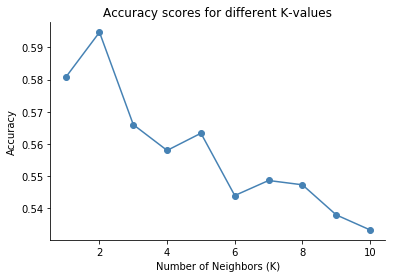

In [12]:
start_time = time.time()

print("[INFO] Calculating accuracy scores...")

max_k_value = 11
knn_accuracy_scores = find_best_accuracy_score(x_train, x_test, y_train, y_test, max_k_value)
best_k_value = np.argmax(knn_accuracy_scores)+1

print('[INFO] Accuracy scores: '+'{}'.format(knn_accuracy_scores))
print("[INFO] KNN model best accuracy score is {:.2f}% for K-value {}".
      format(knn_accuracy_scores[best_k_value]*100, best_k_value)+'.')

end_time = time.time()
print("[INFO] Time elapsed: {:.2f} seconds".format(end_time-start_time))

ax = plt.subplot(111)
ax.plot(range(1, max_k_value), knn_accuracy_scores, marker="o", color='steelblue', label="accuracy score")
ax.set_title('Accuracy scores for different K-values')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Neighbors (K)')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

As we can see, the accuracy score for the Non-Deep Learning model is much worse than it was using the Deep Learning.

## 5. Conclusions

- Data Preparation - Creating a high-quality dataset is time and labor intensive. In future developments if the model contains more data, more automated techniques could be considered as an alternative.
- Model Complexity - The more classes in the model, the more data they need to be trained to distinguish different details.
- Training Time: The Deep Learning model training time (05:03:41) exceeded the Non-Deep Learning model (00:38:38) quite a lot.
- Prediction Accuracy: The Deep Learning model prediction accuracy (92%) outperformed Non-Deep Learning (57%) quite a lot. This is because in Non-Deep Learning even small changes in image rotation, translation or scale can significantly influence the feature representation.
- Model Optimization: Dropout rate proved to be effective hyperparameter to avoid overfitting and increase the model's generalization power. With initial 0.3 dropout rate, the model faced overfitting. In model tuning, the dropout was increased to 0.5 and that lowered the spread between the training and validation accuracies.
- Overall Assessment: Despite rather small dataset the achieved prediction accuracy can be considered as a good result.

## 6. Proposals for Further Developments

- Use Case: Increase Complexity (add more data and increase number of classes), implement image recognition on video files, objects counting etc.
- Data Preparation: Use pretrained model or partial manual control to reduce the time for data cleaning.
- Model Definition: Try different architecture or transfer learning.
- Model Training: Add GPU support to reduce the training time. This requires Nvidia GPU, as Keras doesn't work with AMD GPU yet.
- Model Tuning: Try different optimization and activation functions.